# TODO

If I want to use the overlap background of shared genes with any associations (i.e. 9000), then I should also filter to the input genes that are shared right??
Maybe I should just use the 20k for now.

# SetUp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
import obonet as obo
from scipy.stats import wilcoxon, mannwhitneyu

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [3]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/FigureOverlap/'

In [4]:
blue='#6ec1e0'
green='#5fad56'

## Load data

In [5]:
pcnet2_nodes = pd.read_csv(os.path.join(datadir, 'inputs', 'pcnet2_0_nodes.txt'), sep='\t', header=None, names=['Entrez', 'degree'])
all_nodes = pcnet2_nodes.Entrez.unique()

In [6]:
rv_gda = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t')
cv_gda = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t")
cv_study_info = pd.read_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned_Jan29_2025.txt'), sep='\t')

In [7]:
#cv_gda = cv_gda.drop(columns=['TRAIT_CODE', 'MAPPED_TRAIT_URI']).merge(cv_study_info.drop(columns=['COHORT', 'ASSOCIATION COUNT', 'SUMMARY STATS LOCATION' ]), on=['STUDY ACCESSION', "DISEASE/TRAIT"])
cv_gda['TRAIT_CODE'] = cv_gda.TRAIT_CODE.apply(lambda x: x.replace(':', "_"))
studies_with_background = cv_study_info[~cv_study_info['MAPPED BACKGROUND TRAIT URI'].isna()]['STUDY ACCESSION'].values
cv_gda = cv_gda[~cv_gda['STUDY ACCESSION'].isin(studies_with_background)]

In [8]:
rv_gda = rv_gda[rv_gda.Entrez.isin(all_nodes)]
cv_gda = cv_gda[cv_gda.Entrez.isin(all_nodes)]

# Figures
## RAVAR / GWAS Catalog Overlap

In [9]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

In [10]:
###
over_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/March_2025/RV_GC_overlap.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])

over_df['EFO'] = over_df.trait_pair.apply(lambda x: map_trait_code(x))
over_df['StudyC'] = over_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
over_df['StudyR'] = over_df.trait_pair.apply(lambda x: x.split('_')[0])
over_df['Expected'] = over_df.n_rare * over_df.n_common / 19000
over_df['logp'] = -1 * np.log10(over_df['pval'] + 1e-250)
over_df.shape

(373, 12)

In [11]:
over_df[over_df.StudyC=='GCST90104907']

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp
175,34375979_EFO_0010822_GCST90104907_EFO_0010822,defaults,3,14,0,19000,0.002209,EFO_0010822,GCST90104907,34375979,0.002211,2.655802


### Geneset Sizes

Common max 670
Rare max 168


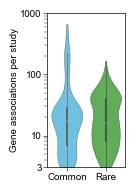

In [12]:
_ = plt.figure(figsize=(1,2))
sns.violinplot(y=over_df.drop_duplicates(subset=['EFO', 'StudyC']).n_common, x=1, cut=0,  color=blue, log_scale=True,
              inner_kws={}, saturation=1)
sns.violinplot(y=over_df.drop_duplicates(subset=['EFO', 'StudyC']).n_rare,x=2, cut=0, color=green, log_scale=True,
              saturation=1)
plt.ylim(3, 1000)
plt.ylabel('Gene associations per study')
_ = plt.xticks([0,1], ['Common', 'Rare'])
_ = plt.yticks([3, 10, 100, 1000], labels=[3, 10, 100, 1000])
print(f'Common max {over_df.drop_duplicates(subset=["EFO", "StudyC"]).n_common.max()}')
print(f'Rare max {over_df.drop_duplicates(subset=["EFO", "StudyC"]).n_rare.max()}')
plt.savefig(os.path.join(figdir, 'study_association_counts_small.svg'), dpi=400, bbox_inches='tight')

In [13]:
mannwhitneyu(over_df.n_common, over_df.n_rare)

MannwhitneyuResult(statistic=66004.5, pvalue=0.22621626489615465)

In [14]:
wilcoxon(over_df.n_common, over_df.n_rare)

WilcoxonResult(statistic=25731.0, pvalue=0.0006235698473234711)

In [34]:
over_df[over_df.n_overlap>0]

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp
4,31367044_EFO_0004502_GCST90293085_EFO_0004502,defaults,10,6,1,19000,3.735611e-06,EFO_0004502,GCST90293085,31367044,0.003158,5.427638
5,31367044_EFO_0005001_GCST90302070_EFO_0005001,defaults,7,3,1,19000,3.489876e-07,EFO_0005001,GCST90302070,31367044,0.001105,6.457190
7,31367044_EFO_0008595_GCST90301982_EFO_0008595,defaults,32,12,2,19000,9.449011e-07,EFO_0008595,GCST90301982,31367044,0.020211,6.024614
9,31367044_EFO_0009767_GCST90092820_EFO_0009767,defaults,29,3,3,19000,0.000000e+00,EFO_0009767,GCST90092820,31367044,0.004579,250.000000
10,31367044_EFO_0010116_GCST90302117_EFO_0010116,defaults,24,6,1,19000,2.286675e-05,EFO_0010116,GCST90302117,31367044,0.007579,4.640796
...,...,...,...,...,...,...,...,...,...,...,...,...
365,36809768_EFO_0022341_GCST90269705_EFO_0022341,defaults,31,59,11,19000,3.284965e-23,EFO_0022341,GCST90269705,36809768,0.096263,22.483469
366,37262146_EFO_0006335_GCST90310294_EFO_0006335,defaults,670,20,10,19000,1.215873e-11,EFO_0006335,GCST90310294,37262146,0.705263,10.915112
367,37262146_EFO_0006336_GCST90310295_EFO_0006336,defaults,576,12,7,19000,3.024176e-10,EFO_0006336,GCST90310295,37262146,0.363789,9.519393
369,37262146_EFO_0007800_GCST90020232_EFO_0007800,defaults,130,10,1,19000,2.016737e-03,EFO_0007800,GCST90020232,37262146,0.068421,2.695351


### Pvalue distributions

In [15]:
rv_gda = rv_gda.dropna(subset='PMID')
rv_gda['StudyTrait'] = rv_gda['PMID'].astype(int).astype(str)+rv_gda['TRAIT_CODE']

In [16]:
cv_gda['StudyTrait'] = cv_gda['STUDY ACCESSION']+cv_gda['TRAIT_CODE']

In [37]:
from math import comb
from scipy.stats import mannwhitneyu

def get_p_values(gda_df, study, trait):
    if 'logp' not in gda_df.columns:
        gda_df['logp'] = -1 * np.log10(gda_df['P-value'] + 1e-250)
    use_gda = gda_df[gda_df.StudyTrait==f'{study}{trait}'].sort_values('logp', ascending=False).drop_duplicates('Entrez', keep='first')
    return use_gda.loc[:, ('logp', 'Entrez')].set_index('Entrez')

def get_shared_disjoint_medians(studyC, studyR, trait):
    rv_p = get_p_values(rv_gda, studyR, trait)
    cv_p = get_p_values(cv_gda, studyC, trait)
    overlap_genes = rv_p.join(cv_p, lsuffix='r',how='inner').index.values
    disjoint_c = set(cv_p.index.values) - set(overlap_genes)
    disjoint_r = set(rv_p.index.values) - set(overlap_genes)
    # c stats
    if (len(overlap_genes) > 0) & (len(disjoint_c) > 0):
        cDisjoint = cv_p.loc[list(disjoint_c)].logp.median()
        cShared = cv_p.loc[overlap_genes].logp.median()
    else:
        cDisjoint = np.nan
        cShared = np.nan
    # r stats
    if (len(overlap_genes) > 0) & (len(disjoint_r) > 0):
        rDisjoint = rv_p.loc[list(disjoint_r)].logp.median()
        rShared = rv_p.loc[overlap_genes].logp.median()
    else:
        rDisjoint = np.nan
        rShared = np.nan
    return {'rSharedMed': rShared, 'cSharedMed': cShared, 'rOnlyMed':rDisjoint, 'cOnlyMed': cDisjoint}

In [43]:
results = {}
for row in tqdm(over_df.iterrows()):
    #print(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])
    results[row[1]['EFO']] = get_shared_disjoint_medians(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])

373it [00:10, 36.57it/s]


In [45]:
test_df = pd.DataFrame.from_dict(results, orient='index')

In [51]:
x = test_df.merge(over_df, left_on='trait', right_on='EFO')

In [58]:
cv_gda[cv_gda['STUDY ACCESSION']=='GCST90269705'].Entrez.values

array([ 63935, 255738,   4023,  10221,     28, 221037,  57678,  10963,
         8882,   7158,   8854,  80790, 146894,  23460,  84106,   4059,
         5819,  85440,   1952,  64757,   2590,   2646,  64241,  22837,
         3083,  10087,  29958,  84870,   4018,   5340,  51085,   6804])

In [66]:
len(rv_gda[(rv_gda['PMID']==36809768.0) & (rv_gda.TRAIT_CODE) == 'EFO_0022341'].Entrez.values)

0

In [67]:
rv_gda[rv_gda.TRAIT_CODE=='EFO_0022341']

,Gene Symbol,Ensembl ID,Gene Type,CHR,Location,Reported Trait,Trait Label,Trait Ontology id,EFO synonym,P-value,TRAIT_CODE,from,Entrez,PMID,StudyTrait,logp


In [53]:
x[x.n_overlap>0]

,trait,rSharedMed,cSharedMed,rOnlyMed,cOnlyMed,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp
4,EFO_0004502,5.780940,212.397940,5.296107,8.397940,31367044_EFO_0004502_GCST90293085_EFO_0004502,defaults,10,6,1,19000,3.735611e-06,EFO_0004502,GCST90293085,31367044,0.003158,5.427638
5,EFO_0005001,5.695251,107.000000,6.846126,13.000000,31367044_EFO_0005001_GCST90302070_EFO_0005001,defaults,7,3,1,19000,3.489876e-07,EFO_0005001,GCST90302070,31367044,0.001105,6.457190
7,EFO_0008595,17.508919,207.221849,10.114750,13.301030,31367044_EFO_0008595_GCST90301982_EFO_0008595,defaults,32,12,2,19000,9.449011e-07,EFO_0008595,GCST90301982,31367044,0.020211,6.024614
9,EFO_0009767,NaN,31.096910,NaN,9.522879,31367044_EFO_0009767_GCST90092820_EFO_0009767,defaults,29,3,3,19000,0.000000e+00,EFO_0009767,GCST90092820,31367044,0.004579,250.000000
10,EFO_0010116,8.198349,77.045757,5.856049,14.698970,31367044_EFO_0010116_GCST90302117_EFO_0010116,defaults,24,6,1,19000,2.286675e-05,EFO_0010116,GCST90302117,31367044,0.007579,4.640796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,EFO_0022341,NaN,NaN,NaN,NaN,36809768_EFO_0022341_GCST90269705_EFO_0022341,defaults,31,59,11,19000,3.284965e-23,EFO_0022341,GCST90269705,36809768,0.096263,22.483469
366,EFO_0006335,6.110924,17.110924,4.522879,9.221849,37262146_EFO_0006335_GCST90310294_EFO_0006335,defaults,670,20,10,19000,1.215873e-11,EFO_0006335,GCST90310294,37262146,0.705263,10.915112
367,EFO_0006336,5.096910,9.154902,4.045757,9.698970,37262146_EFO_0006336_GCST90310295_EFO_0006336,defaults,576,12,7,19000,3.024176e-10,EFO_0006336,GCST90310295,37262146,0.363789,9.519393
369,EFO_0007800,4.221849,15.000000,4.522879,13.301030,37262146_EFO_0007800_GCST90020232_EFO_0007800,defaults,130,10,1,19000,2.016737e-03,EFO_0007800,GCST90020232,37262146,0.068421,2.695351


In [17]:
from math import comb
from scipy.stats import mannwhitneyu

def get_p_values(gda_df, study, trait):
    if 'logp' not in gda_df.columns:
        gda_df['logp'] = -1 * np.log10(gda_df['P-value'] + 1e-250)
    use_gda = gda_df[gda_df.StudyTrait==f'{study}{trait}'].sort_values('logp', ascending=False).drop_duplicates('Entrez', keep='first')
    return use_gda.loc[:, ('logp', 'Entrez')].set_index('Entrez')

def compare_pval_dists(studyC, studyR, trait):
    rv_p = get_p_values(rv_gda, studyR, trait)
    cv_p = get_p_values(cv_gda, studyC, trait)
    overlap_genes = rv_p.join(cv_p, lsuffix='r',how='inner').index.values
    r_mo, r_mno, r_stat, r_p = perform_p_val_rank_test(rv_p, overlap_genes)
    c_mo, c_mno, c_stat, c_p = perform_p_val_rank_test(cv_p, overlap_genes)
    return {f'{studyR}_{trait}_{studyC}_{trait}': {'rStat':r_stat, 'cStat':c_stat, 'rP':r_p, 'cP':c_p,
                                                  'rSharedMed':r_mo, 'rOnlyMed': r_mno,
                                                  'cSharedMed': c_mo, 'cOnlyMed': c_mno}}

def compare_global_p_dists(over_df):
    common_only = []
    rare_only = []
    common_shared = []
    rare_shared = []
    for row in tqdm(over_df.iterrows()):
        studyC = row[1]['StudyC']
        studyR = row[1]['StudyR']
        trait = row[1]['EFO']
        rv_p = get_p_values(rv_gda, studyR, trait)
        cv_p = get_p_values(cv_gda, studyC, trait)
        overlap_genes = rv_p.join(cv_p, lsuffix='r',how='inner').index.values
        common_only.append(cv_p[~cv_p.index.isin(overlap_genes)])
        rare_only.append(rv_p[~rv_p.index.isin(overlap_genes)])
        common_shared.append(cv_p[cv_p.index.isin(overlap_genes)])
        rare_shared.append(rv_p[rv_p.index.isin(overlap_genes)])
    common_only = pd.concat(common_only).reset_index().assign(Variant='Common', Group='Only')
    rare_only = pd.concat(rare_only).reset_index().assign(Variant='Rare', Group='Only')
    common_shared = pd.concat(common_shared).reset_index().assign(Variant='Common', Group='Shared')
    rare_shared = pd.concat(rare_shared).reset_index().assign(Variant='Rare', Group='Shared')
    return pd.concat([common_only, rare_only, common_shared, rare_shared]).reset_index()

    
def perform_p_val_rank_test(pvals, overlap_genes):
    median_overlap =  pvals[pvals.index.isin(overlap_genes)].logp.median()
    median_non_overlap = pvals[~pvals.index.isin(overlap_genes)].logp.median()
    if is_sample_size_useful(len(pvals), len(overlap_genes)):
        x = mannwhitneyu(pvals[~pvals.index.isin(overlap_genes)], pvals[pvals.index.isin(overlap_genes)])
        return median_overlap, median_non_overlap, x.statistic[0], x.pvalue[0]
    else:
        return median_overlap, median_non_overlap, np.nan, np.nan

def is_sample_size_useful(n_total, n_overlap):
    if n_overlap == 0:
        return False
    if 2 / comb(n_total, n_overlap) > 0.05:
        return False
    else:
        return True

In [18]:
2/comb(8, 2)

0.07142857142857142

In [19]:
mannwhitneyu([0,1,2,3,4,5], [6,7])

MannwhitneyuResult(statistic=0.0, pvalue=0.07142857142857142)

In [20]:
results = {}
for row in tqdm(over_df.iterrows()):
    #print(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])
    results = {**results,  **compare_pval_dists(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])}

373it [00:10, 35.50it/s]


In [21]:
test_df = pd.DataFrame.from_dict(results, orient='index')

In [35]:
test_df.describe()

,rStat,cStat,rP,cP,rSharedMed,rOnlyMed,cSharedMed,cOnlyMed
count,45.000000,54.000000,45.000000,5.400000e+01,72.000000,242.000000,72.000000,355.000000
mean,83.644444,298.842593,0.419206,2.077393e-01,19.548059,6.567637,55.158202,12.787614
std,358.132699,1028.450051,0.332157,2.777666e-01,26.414737,4.758427,62.597024,6.815067
min,1.000000,0.000000,0.000439,3.784062e-08,4.221849,4.045757,6.522879,5.045757
25%,6.000000,14.375000,0.097561,1.414736e-02,7.960175,4.312694,16.494535,8.022879
50%,15.000000,44.000000,0.436364,6.143978e-02,10.687653,4.410609,28.816902,11.045757
75%,31.500000,137.125000,0.746814,2.621122e-01,17.551178,6.712046,65.879674,16.000000
max,2405.000000,7260.500000,1.000000,1.000000e+00,133.623592,36.252588,300.000000,62.221849


In [22]:
test_df.dropna(subset='cP').shape

(54, 8)

In [23]:
# proportion that could be assessed
len(test_df.dropna())/len(test_df)

0.10723860589812333

In [29]:
test_df2 = test_df.dropna(subset=['rSharedMed', 'cSharedMed'])

In [26]:
test_df2 = test_df.dropna()

In [25]:
# what is the best way to assess this with such a small number of overlapping traits. Doing rare and common separately would 
# give a few more traits to work with. 
# Also, once I have the UKB traits I can add these too? Looks like the effect might be stronger for common variants which I
# think is to be expected. 

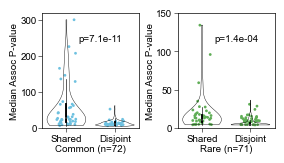

In [31]:
_, [ax1, ax2] = plt.subplots( nrows=1, ncols=2, figsize=(3, 1.5), gridspec_kw={'wspace':0.4})
sns.violinplot(test_df.melt(value_vars=[ 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, fill=False, palette=['k','k'], linewidth=0.3,
              order = [ 'cSharedMed', 'cOnlyMed',], zorder=2, ax=ax1)
sns.stripplot(test_df.dropna().melt(value_vars=[ 'cSharedMed', 'cOnlyMed'], 
                                    var_name='Set', value_name='MedP'), palette=[blue, blue],
              order= [ 'cSharedMed', 'cOnlyMed'],jitter=0.2,
              x='Set', y='MedP', hue='Set', edgecolor='black', s=2, zorder=1, ax=ax1)

sns.violinplot(test_df.melt(value_vars=['rSharedMed', 'rOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, fill=False, palette=['k', 'k'], linewidth=0.3,
              order = [ 'rSharedMed', 'rOnlyMed'], zorder=2, ax=ax2)
sns.stripplot(test_df.dropna().melt(value_vars=[ 'rSharedMed', 'rOnlyMed'], 
                                    var_name='Set', value_name='MedP'), palette=[ green, green],
              order= [ 'rSharedMed', 'rOnlyMed'],jitter=0.2,
              x='Set', y='MedP', hue='Set', edgecolor='black', s=2, zorder=1, ax=ax2)

common_df = test_df.loc[:, ('cSharedMed', 'cOnlyMed')].dropna()
rare_df = test_df.loc[:, ('rSharedMed', 'rOnlyMed')].dropna()

p_common = wilcoxon(common_df.cSharedMed, common_df.cOnlyMed).pvalue
p_rare = wilcoxon(rare_df.rSharedMed, rare_df.rOnlyMed).pvalue


for i, ax in enumerate([ax1, ax2]):
    ax.set_xticks([0,1], labels=['Shared', 'Disjoint'])
    ax.set_xlabel(f'{["Common", "Rare"][i]} (n={[len(common_df), len(rare_df)][i]})')
    ax.set_ylim(0, [320, 150][i])
    ax.text(x=0.25, y=[320, 150][i]*0.75, s=f'p={[p_common, p_rare][i]:.1e}')
    ax.set_ylabel('Median Assoc P-value')
#plt.savefig(os.path.join(figdir, 'p_value_comparison.svg'),bbox_inches='tight')

<Axes: xlabel='Set', ylabel='P'>

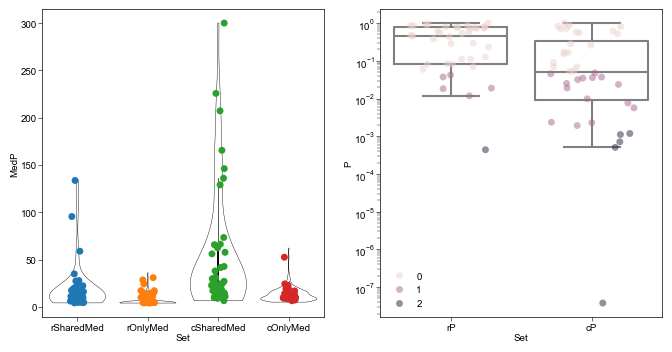

In [27]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.violinplot(test_df.melt(value_vars=['rSharedMed', 'rOnlyMed', 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, ax=ax1, fill=False, palette=['k','k','k', 'k'], linewidth=0.3)
sns.stripplot(test_df.dropna().melt(value_vars=['rSharedMed', 'rOnlyMed', 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', ax=ax1, edgecolor='black')
plot_df = test_df2.melt(value_vars=['rP', 'cP'], var_name='Set', value_name='P')
plot_df['Sig'] = plot_df.P.apply(lambda x: 0 if x > 0.05 else 1 if x > 0.1/len(plot_df) else 2)
sns.stripplot(plot_df, jitter=0.3,
              x='Set', y='P', hue='Sig', log_scale=True, alpha=0.5, ax=ax2)
sns.boxplot(plot_df, x='Set', y='P', log_scale=True, fliersize=0, fill=False, color='grey', ax=ax2)

(-0.5, 1.5)

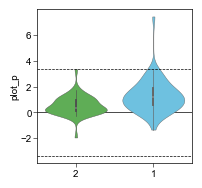

In [28]:
_ = plt.figure(figsize=(2,2))

rare_df = test_df.loc[:, ('rP', 'rSharedMed', 'rOnlyMed')].dropna()
rare_df['logp'] = rare_df.rP.apply(lambda x: -1 * np.log10(x))
rare_df = rare_df.assign(minus_logp = rare_df['logp'] * -1)
rare_df['plot_p'] = rare_df.apply(lambda x: x.logp if x.rSharedMed > x.rOnlyMed else x.minus_logp, axis=1)
sns.violinplot(rare_df, y='plot_p', x=2, cut=0, color=green, 
                       density_norm='count', orient='v', linewidth=0.3, saturation=1, zorder=1)

common_df = test_df.loc[:, ('cP', 'cSharedMed', 'cOnlyMed')].dropna()
common_df['logp'] = common_df.cP.apply(lambda x: -1 * np.log10(x))
common_df = common_df.assign(minus_logp = common_df['logp'] * -1)
common_df['plot_p'] = common_df.apply(lambda x: x.logp if x.cSharedMed > x.cOnlyMed else x.minus_logp, axis=1)
sns.violinplot(common_df, y='plot_p', x=1, cut=0, color=blue, 
                       density_norm='count', orient='v', linewidth=0.3, saturation=1, zorder=2)

plt.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=0)
plt.hlines(y=-1*np.log10(0.0004), xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=3, linestyle='--')
plt.hlines(y=np.log10(0.0004), xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=3, linestyle='--')
plt.xlim(-0.5, 1.5)



## Overlap spectrum

In [29]:
r_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/March_2025', 'rare_Mar28.traitlist'), header=None)[0].values
c_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/March_2025', 'common_Mar28.traitlist'), header=None)[0].values
pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]

In [30]:
over_df.head()

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp
0,20549515_EFO_0001645_GCST90132305_EFO_0001645,defaults,35,4,0,19000,0.007349,EFO_0001645,GCST90132305,20549515,0.007368,2.133792
1,25583502_EFO_0004340_GCST90179150_EFO_0004340,defaults,624,5,0,19000,0.153788,EFO_0004340,GCST90179150,25583502,0.164211,0.813077
2,28089252_EFO_0004833_GCST90002355_EFO_0004833,defaults,200,7,0,19000,0.071409,EFO_0004833,GCST90002355,28089252,0.073684,1.146249
3,29185836_GO_0070527_GCST000693_GO_0070527,defaults,5,22,0,19000,0.005777,GO_0070527,GCST000693,29185836,0.005789,2.238321
4,31367044_EFO_0004502_GCST90293085_EFO_0004502,defaults,10,6,1,19000,0.000004,EFO_0004502,GCST90293085,31367044,0.003158,5.427638


In [31]:
top_over_df = over_df[over_df.trait_pair.isin(pairs)]
top_over_df.shape

(373, 12)

In [32]:
fdrcorrection(top_over_df.pval.values)

NameError: name 'fdrcorrection' is not defined

In [33]:
from statsmodels.stats.multitest import fdrcorrection
top_over_df['q'] = fdrcorrection(top_over_df.pval.values)[1]

In [34]:
top_over_df['J'] = top_over_df.n_overlap / (top_over_df.n_common + top_over_df.n_rare - top_over_df.n_overlap)

In [35]:
top_over_df.sort_values('J', ascending=False)

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp,q,J
152,34375979_EFO_0007805_GCST90025956_EFO_0007805,defaults,22,17,11,19000,8.668892e-34,EFO_0007805,GCST90025956,34375979,0.019684,33.062036,5.389161e-32,0.392857
122,34375979_EFO_0004615_GCST90025952_EFO_0004615,defaults,9,9,5,19000,1.080279e-19,EFO_0004615,GCST90025952,34375979,0.004263,18.966464,7.326256e-19,0.384615
155,34375979_EFO_0007986_GCST90025972_EFO_0007986,defaults,21,16,9,19000,1.670446e-27,EFO_0007986,GCST90025972,34375979,0.017684,26.777168,4.153841e-26,0.321429
21,34226706_EFO_0007788_GCST90025996_EFO_0007788,defaults,3,6,2,19000,1.749802e-11,EFO_0007788,GCST90025996,34226706,0.000947,10.757011,5.987856e-11,0.285714
125,34375979_EFO_0004631_GCST90025967_EFO_0004631,defaults,4,5,2,19000,3.499329e-11,EFO_0004631,GCST90025967,34375979,0.001053,10.456015,1.165401e-10,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,34375979_EFO_0008401_GCST005001_EFO_0008401,defaults,21,6,0,19000,6.614150e-03,EFO_0008401,GCST005001,34375979,0.006632,2.179526,8.334723e-03,0.000000
151,34375979_EFO_0007490_GCST90018922_EFO_0007490,defaults,7,18,0,19000,6.613802e-03,EFO_0007490,GCST90018922,34375979,0.006632,2.179549,8.334723e-03,0.000000
150,34375979_EFO_0007429_GCST90269781_EFO_0007429,defaults,4,10,0,19000,2.103768e-03,EFO_0007429,GCST90269781,34375979,0.002105,2.677002,3.367834e-03,0.000000
149,34375979_EFO_0007326_GCST005002_EFO_0007326,defaults,15,5,0,19000,3.941555e-03,EFO_0007326,GCST005002,34375979,0.003947,2.404332,5.506367e-03,0.000000


In [36]:
x = top_over_df[(top_over_df.n_overlap != 0) & (top_over_df.q < 0.05)]
(x.n_overlap / x.n_common).describe()

count    184.000000
mean       0.269741
std        0.186669
min        0.004255
25%        0.102586
50%        0.275253
75%        0.400000
max        0.750000
dtype: float64

In [37]:
top_over_df['rare_only'] = top_over_df.n_rare - top_over_df.n_overlap
top_over_df['common_only'] = top_over_df.n_common - top_over_df.n_overlap
top_over_df['total'] = top_over_df.rare_only + top_over_df.common_only + top_over_df.n_overlap
top_over_df['overlap+rare'] = top_over_df.n_overlap + top_over_df.rare_only
top_over_df = top_over_df.sort_values(by=['n_overlap', 'total'], ascending=False)

In [38]:
top_over_df['logq'] = top_over_df.q.apply(lambda x: -1 * np.log10(x+1e-50))

In [39]:
plot_df=top_over_df[(top_over_df.param_set=='defaults') & ((top_over_df.total > 100) ) & (top_over_df.total < 1000)].melt(id_vars=['trait_pair', 'q', 'logq'], value_vars=['n_overlap', 'overlap+rare', 'total'])

In [40]:
total_order = top_over_df[top_over_df.param_set=='defaults'].sort_values(by=['n_overlap', 'n_rare', 'n_common'], ascending=[False, False, False]).trait_pair.values

In [41]:
plot_df.columns

Index(['trait_pair', 'q', 'logq', 'variable', 'value'], dtype='object')

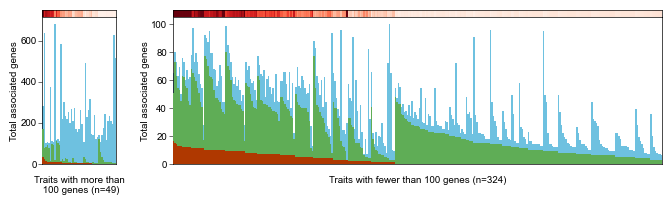

In [42]:
_, [[ax1a, ax2a], [ax1, ax2]] = plt.subplots(2, 2, figsize=(8, 2), sharex=False, 
                                             gridspec_kw={'height_ratios': [1, 20], 'width_ratios':[49,324], 'hspace': 0})



order = [x for x in total_order if x in plot_df.trait_pair.values]
n1=len(order)
#plot_df[plot_df.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair
sns.heatmap(np.array(plot_df[plot_df.variable=='total'].set_index('trait_pair').loc[order]['logq']).reshape(-1, 1).T,
            ax=ax1a, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False,vmax=25, vmin=0)

sns.barplot(plot_df[plot_df.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', zorder=10, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', zorder=5, order=order,
            saturation=1,  ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', zorder=1, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
ax1.set_xticks([])


plot_df2 =top_over_df[(top_over_df.param_set=='defaults')  & (top_over_df.total <= 100)].melt(id_vars=['trait_pair', 'q', 
                                                                                                       'logq'], 
                                                                  value_vars=['n_overlap', 'overlap+rare', 'total'])
order = [x for x in total_order if x in plot_df2.trait_pair.values]
#plot_df2[plot_df2.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair

n2=len(order)
sns.heatmap(np.array(plot_df2[plot_df2.variable=='total'].set_index('trait_pair').loc[order]['logq']).reshape(-1, 1).T, 
            ax=ax2a, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df2[plot_df2.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', 
            zorder=10, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', 
            zorder=5, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', 
            zorder=1, order=order, ax=ax2, alpha=1, saturation=1, width=1)
ax2.set_xticks([])
ax1.set_xlabel(f'\nTraits with more than\n 100 genes (n={n1})')
ax2.set_xlabel(f'\nTraits with fewer than 100 genes (n={n2})')
_ = ax1.set_ylabel('Total associated genes')
_ = ax2.set_ylabel('Total associated genes')

for ax in [ax1a, ax2a]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        
plt.savefig(os.path.join(figdir, 'overlap_summary_gcat.svg'), dpi=400, bbox_inches='tight')

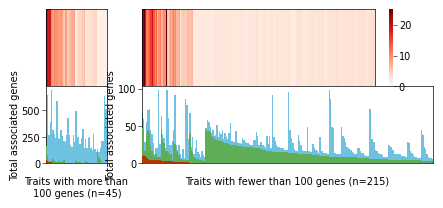

In [298]:
_, [[ax1a, ax2a], [ax1, ax2]] = plt.subplots(2, 2, figsize=(5, 2), sharex=False, gridspec_kw={'height_ratios': [20, 20], 'width_ratios':[45,215], 'hspace': 0})


plt.rcParams.update({'font.size': 7})
order = [x for x in total_order if x in plot_df.trait_pair.values]
n1=len(order)
#plot_df[plot_df.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair
sns.heatmap(np.array(plot_df[plot_df.variable=='total'].set_index('trait_pair').loc[order]['logp']).reshape(-1, 1).T, ax=ax1a, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False,vmax=25, vmin=0)

sns.barplot(plot_df[plot_df.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', zorder=10, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', zorder=5, order=order,
            saturation=1,  ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', zorder=1, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
ax1.set_xticks([])


plot_df2 =top_over_df[(top_over_df.param_set=='defaults')  & (top_over_df.total <= 100)].melt(id_vars=['trait_pair', 'pval', 'logp'], value_vars=['n_overlap', 'overlap+rare', 'total'])
order = [x for x in total_order if x in plot_df2.trait_pair.values]
#plot_df2[plot_df2.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair

n2=len(order)
sns.heatmap(np.array(plot_df2[plot_df2.variable=='total'].set_index('trait_pair').loc[order]['logp']).reshape(-1, 1).T, 
            ax=ax2a, cbar=True,
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df2[plot_df2.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', 
            zorder=10, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', 
            zorder=5, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', 
            zorder=1, order=order, ax=ax2, alpha=1, saturation=1, width=1)
ax2.set_xticks([])
ax1.set_xlabel(f'\nTraits with more than\n 100 genes (n={n1})')
ax2.set_xlabel(f'\nTraits with fewer than 100 genes (n={n2})')
_ = ax1.set_ylabel('Total associated genes')
_ = ax2.set_ylabel('Total associated genes')

for ax in [ax1a, ax2a]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        
plt.savefig(os.path.join(figdir, 'overlap_summary_gcat_legend.svg'), dpi=400, bbox_inches='tight')

In [44]:
features = pd.read_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_Mar28.tsv'), sep='\t')

In [45]:
features['trait_pair'] = features.StudyR + '_' + features.StudyC

In [46]:
over_df = over_df.merge(features.drop(columns=['StudyC', 'StudyR']), on='trait_pair')

In [47]:
over_df['plot_type'] = over_df.apply(lambda z: 'CC' if z.trait_type=='CC' else z.Domain, axis=1)
over_df['plot_type'] = over_df.plot_type.apply(lambda z: z if z in ['CC', 'Metabolic', 'Lipid Measurment', 
                                                                                 'Hematological'] else 'Other Continuous')

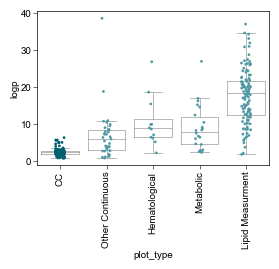

In [48]:
_ = plt.figure(figsize=(3, 2))
sns.stripplot(over_df[over_df.logp < 50], x='plot_type', y='logp', s=2, hue='plot_type',
             palette=['#00606f','#509AA6','#509AA6','#509AA6','#509AA6' ])
sns.boxplot(over_df[over_df.logp < 50], x='plot_type', y='logp', fill=False, color='grey', fliersize=0, linewidth=0.4)
plt.gca().tick_params(axis='x', rotation=90)

In [49]:
counts_q={}
counts_cc = {}
for lo,hi in [(0,0), (1,2), (3, 4), (5,6), (7,8), (9,10), (11,40)]:
    c_df = over_df[over_df.trait_type=='CC']
    q_df = over_df[over_df.trait_type=='Q']
    counts_cc[f'{lo}-{hi}'] = c_df[(c_df.n_overlap >= lo) & (c_df.n_overlap<=hi)].shape[0]
    counts_q[f'{lo}-{hi}'] = q_df[(q_df.n_overlap >= lo) & (q_df.n_overlap<=hi)].shape[0]

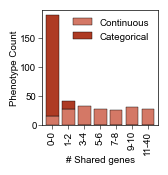

In [51]:
_ = plt.figure(figsize=(1.5,1.5))
ax=plt.gca()
pd.DataFrame({'Continuous':counts_q, 'Categorical':counts_cc}).plot(kind='bar', stacked=True, edgecolor='black', linewidth=0.3, width=0.8,
                                                                             ax=ax, color=[ '#D47866', '#AE3B24',])
ax.set_ylabel('Phenotype Count')
ax.set_xlabel('# Shared genes')
plt.savefig(os.path.join(figdir, 'shared_gene_counts.svg'), bbox_inches='tight')

# With UKB/UKB filtering

In [28]:
over_df_uk =  pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/UKB/ukb_overlap.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])
filtered_ukb = pd.read_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/filtered_matched_traits.tsv', sep='\t', index_col=0)
filtered_ukb['StudyC_clean'] = filtered_ukb.StudyC.apply(lambda z: z.replace(': https://doi.org/10.1101/', '').replace('UK2', 'UKB2'))

In [31]:
filtered_ukb['trait_pair'] = filtered_ukb['StudyR'] + '_' + filtered_ukb['StudyC_clean']

In [35]:
over_df_uk = over_df_uk[over_df_uk.trait_pair.isin(filtered_ukb.trait_pair.values)]
over_df_uk['Expected'] = over_df_uk.n_rare * over_df_uk.n_common / 9000
over_df_uk['logp'] = -1 * np.log10(over_df_uk['pval'] + 1e-250)

Common max 682
Rare max 119


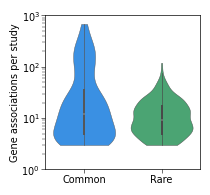

In [38]:
_ = plt.figure(figsize=(2,2))
sns.violinplot(y=over_df.drop_duplicates(subset=['EFO', 'StudyC']).n_common, x=1, cut=0,  color='dodgerblue', log_scale=True)
sns.violinplot(y=over_df.drop_duplicates(subset=['EFO', 'StudyC']).n_rare,x=2, cut=0, color='mediumseagreen', log_scale=True)
plt.ylim(1, 1000)
plt.ylabel('Gene associations per study')
_ = plt.xticks([0,1], ['Common', 'Rare'])
print(f'Common max {over_df.drop_duplicates(subset=["EFO", "StudyC"]).n_common.max()}')
print(f'Rare max {over_df.drop_duplicates(subset=["EFO", "StudyC"]).n_rare.max()}')
plt.savefig(os.path.join(figdir, 'study_association_counts.png'), dpi=400, bbox_inches='tight')

Common max 8327
Rare max 1197


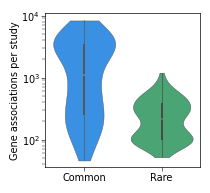

In [44]:
_ = plt.figure(figsize=(2,2))
sns.violinplot(y=over_df_uk.n_common, x=1, cut=0,  color='dodgerblue', log_scale=True)
sns.violinplot(y=over_df_uk.n_rare,x=2, cut=0, color='mediumseagreen', log_scale=True)
#plt.ylim(3, 1000)
plt.ylabel('Gene associations per study')
_ = plt.xticks([0,1], ['Common', 'Rare'])
print(f'Common max {over_df_uk.n_common.max()}')
print(f'Rare max {over_df_uk.n_rare.max()}')
plt.savefig(os.path.join(figdir, 'study_association_counts_uk.png'), dpi=400, bbox_inches='tight')

In [43]:
over_df_uk.n_rare.describe()

count      86.000000
mean      263.930233
std       201.382971
min        52.000000
25%       102.500000
50%       214.500000
75%       369.250000
max      1197.000000
Name: n_rare, dtype: float64

## Input overlap

Select the pair with the greatest overlap in terms of number of genes between RC per trait    
Fixed issue with trait_code not accepting MONDO, HP etc.

In [45]:
r_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/March_2025', 'rare.traitlist'), header=None)[0].values
c_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/March_2025', 'common.traitlist'), header=None)[0].values
pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]

In [46]:
over_df.head()

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp
0,20549515_EFO_0000384_GCST90446792_EFO_0000384,defaults,102,9,2,19000,0.000012,EFO_0000384,GCST90446792,20549515,0.102000,4.909190
1,20549515_EFO_0000685_GCST90018910_EFO_0000685,defaults,11,5,0,19000,0.002892,EFO_0000685,GCST90018910,20549515,0.006111,2.538848
2,20549515_EFO_0001645_GCST90132315_EFO_0001645,defaults,23,4,0,19000,0.004834,EFO_0001645,GCST90132315,20549515,0.010222,2.315720
3,20549515_MONDO_0005148_GCST90018926_MONDO_0005148,defaults,108,3,0,19000,0.016957,MONDO_0005148,GCST90018926,20549515,0.036000,1.770657
4,24212883_EFO_0000676_GCST90435379_EFO_0000676,defaults,4,6,0,19000,0.001263,EFO_0000676,GCST90435379,24212883,0.002667,2.898714


In [47]:
top_over_df = over_df[over_df.trait_pair.isin(pairs)]
top_over_df.shape

(261, 12)

In [48]:
top_over_df['rare_only'] = top_over_df.n_rare - top_over_df.n_overlap
top_over_df['common_only'] = top_over_df.n_common - top_over_df.n_overlap
top_over_df['total'] = top_over_df.rare_only + top_over_df.common_only + top_over_df.n_overlap
top_over_df['overlap+rare'] = top_over_df.n_overlap + top_over_df.rare_only
top_over_df = top_over_df.sort_values(by=['n_overlap', 'total'], ascending=False)

In [49]:
plot_df=top_over_df[(top_over_df.param_set=='defaults') & ((top_over_df.total > 100) ) & (top_over_df.total < 1000)].melt(id_vars=['trait_pair', 'pval', 'logp'], value_vars=['n_overlap', 'overlap+rare', 'total'])

In [50]:
total_order = top_over_df[top_over_df.param_set=='defaults'].sort_values(by=['n_overlap', 'n_rare', 'n_common'], ascending=[False, False, False]).trait_pair.values

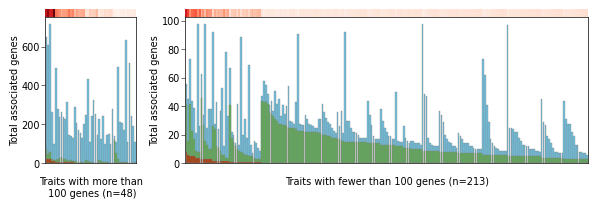

In [76]:
_, [[ax1a, ax2a], [ax1, ax2]] = plt.subplots(2, 2, figsize=(7, 2), sharex=False, gridspec_kw={'height_ratios': [1, 20], 'width_ratios':[48,213], 'hspace': 0})


plt.rcParams.update({'font.size': 7})
order = [x for x in total_order if x in plot_df.trait_pair.values]
n1=len(order)
#plot_df[plot_df.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair
sns.heatmap(np.array(plot_df[plot_df.variable=='total'].set_index('trait_pair').loc[order]['logp']).reshape(-1, 1).T, ax=ax1a, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False,vmax=25, vmin=0)

sns.barplot(plot_df[plot_df.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', zorder=10, order=order, 
            saturation=1, ax=ax1, alpha=1, width=0.9, edgecolor='grey')
sns.barplot(plot_df[plot_df.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', zorder=5, order=order,
            saturation=1,  ax=ax1, alpha=1, width=0.9, edgecolor='grey')
sns.barplot(plot_df[plot_df.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', zorder=1, order=order, 
            saturation=1, ax=ax1, alpha=1, width=0.9, edgecolor='grey')
ax1.set_xticks([])


plot_df2 =top_over_df[(top_over_df.param_set=='defaults')  & (top_over_df.total <= 100)].melt(id_vars=['trait_pair', 'pval', 'logp'], value_vars=['n_overlap', 'overlap+rare', 'total'])
order = [x for x in total_order if x in plot_df2.trait_pair.values]
#plot_df2[plot_df2.variable=='n_overlap'].sort_values('value', ascending=False).trait_pair

n2=len(order)
sns.heatmap(np.array(plot_df2[plot_df2.variable=='total'].set_index('trait_pair').loc[order]['logp']).reshape(-1, 1).T, 
            ax=ax2a, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df2[plot_df2.variable=='n_overlap'], x='trait_pair', y='value', color='#af3800', zorder=10, order=order, ax=ax2, alpha=1, saturation=1, width=0.9, edgecolor='grey')
sns.barplot(plot_df2[plot_df2.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', zorder=5, order=order, ax=ax2, alpha=1, saturation=1, width=0.9, edgecolor='grey')
sns.barplot(plot_df2[plot_df2.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', zorder=1, order=order, ax=ax2, alpha=1, saturation=1, width=0.9, edgecolor='grey')
ax2.set_xticks([])
ax1.set_xlabel(f'\nTraits with more than\n 100 genes (n={n1})')
ax2.set_xlabel(f'\nTraits with fewer than 100 genes (n={n2})')
_ = ax1.set_ylabel('Total associated genes')
_ = ax2.set_ylabel('Total associated genes')
plt.savefig(os.path.join(figdir, 'overlap_summary_gcat.svg'), dpi=400, bbox_inches='tight')

### P-values of overlap vs rare/common only

In [82]:
over_df.head()

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp
0,20549515_EFO_0000384_GCST90446792_EFO_0000384,defaults,102,9,2,19000,0.000012,EFO_0000384,GCST90446792,20549515,0.102000,4.909190
1,20549515_EFO_0000685_GCST90018910_EFO_0000685,defaults,11,5,0,19000,0.002892,EFO_0000685,GCST90018910,20549515,0.006111,2.538848
2,20549515_EFO_0001645_GCST90132315_EFO_0001645,defaults,23,4,0,19000,0.004834,EFO_0001645,GCST90132315,20549515,0.010222,2.315720
3,20549515_MONDO_0005148_GCST90018926_MONDO_0005148,defaults,108,3,0,19000,0.016957,MONDO_0005148,GCST90018926,20549515,0.036000,1.770657
4,24212883_EFO_0000676_GCST90435379_EFO_0000676,defaults,4,6,0,19000,0.001263,EFO_0000676,GCST90435379,24212883,0.002667,2.898714


In [85]:
from math import comb
from scipy.stats import mannwhitneyu

def get_p_values(gda_df, study, trait):
    if 'logp' not in gda_df.columns:
        gda_df['logp'] = -1 * np.log10(gda_df['P-value'] + 1e-250)
    use_gda = gda_df[gda_df.StudyTrait==f'{study}{trait}'].sort_values('logp', ascending=False).drop_duplicates('Entrez', keep='first')
    return use_gda.loc[:, ('logp', 'Entrez')].set_index('Entrez')

def compare_pval_dists(studyC, studyR, trait):
    rv_p = get_p_values(rv_gda, studyR, trait)
    cv_p = get_p_values(cv_gda, studyC, trait)
    overlap_genes = rv_p.join(cv_p, lsuffix='r',how='inner').index.values
    r_mo, r_mno, r_stat, r_p = perform_p_val_rank_test(rv_p, overlap_genes)
    c_mo, c_mno, c_stat, c_p = perform_p_val_rank_test(cv_p, overlap_genes)
    return {f'{studyR}_{trait}_{studyC}_{trait}': {'rStat':r_stat, 'cStat':c_stat, 'rP':r_p, 'cP':c_p,
                                                  'rSharedMed':r_mo, 'rOnlyMed': r_mno,
                                                  'cSharedMed': c_mo, 'cOnlyMed': c_mno}}

def compare_global_p_dists(over_df):
    common_only = []
    rare_only = []
    common_shared = []
    rare_shared = []
    for row in tqdm(over_df.iterrows()):
        studyC = row[1]['StudyC']
        studyR = row[1]['StudyR']
        trait = row[1]['EFO']
        rv_p = get_p_values(rv_gda, studyR, trait)
        cv_p = get_p_values(cv_gda, studyC, trait)
        overlap_genes = rv_p.join(cv_p, lsuffix='r',how='inner').index.values
        common_only.append(cv_p[~cv_p.index.isin(overlap_genes)])
        rare_only.append(rv_p[~rv_p.index.isin(overlap_genes)])
        common_shared.append(cv_p[cv_p.index.isin(overlap_genes)])
        rare_shared.append(rv_p[rv_p.index.isin(overlap_genes)])
    common_only = pd.concat(common_only).reset_index().assign(Variant='Common', Group='Only')
    rare_only = pd.concat(rare_only).reset_index().assign(Variant='Rare', Group='Only')
    common_shared = pd.concat(common_shared).reset_index().assign(Variant='Common', Group='Shared')
    rare_shared = pd.concat(rare_shared).reset_index().assign(Variant='Rare', Group='Shared')
    return pd.concat([common_only, rare_only, common_shared, rare_shared]).reset_index()

    
def perform_p_val_rank_test(pvals, overlap_genes):
    median_overlap =  pvals[pvals.index.isin(overlap_genes)].logp.median()
    median_non_overlap = pvals[~pvals.index.isin(overlap_genes)].logp.median()
    if is_sample_size_useful(len(pvals), len(overlap_genes)):
        x = mannwhitneyu(pvals[~pvals.index.isin(overlap_genes)], pvals[pvals.index.isin(overlap_genes)])
        return median_overlap, median_non_overlap, x.statistic[0], x.pvalue[0]
    else:
        return median_overlap, median_non_overlap, np.nan, np.nan

def is_sample_size_useful(n_total, n_overlap):
    if n_overlap == 0:
        return False
    if 2 / comb(n_total, n_overlap) > 0.05:
        return False
    else:
        return True

In [99]:
results = {}
for row in tqdm(top_over_df.iterrows()):
    #print(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])
    results = {**results,  **compare_pval_dists(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])}

261it [00:07, 34.89it/s]


In [100]:
test_df = pd.DataFrame.from_dict(results, orient='index')

In [112]:
test_df.dropna(subset='cP').shape

(61, 8)

In [101]:
# proportion that could be assessed
len(test_df.dropna())/len(test_df)

0.14942528735632185

In [106]:
test_df2 = test_df.dropna()

In [ ]:
# what is the best way to assess this with such a small number of overlapping traits. Doing rare and common separately would 
# give a few more traits to work with. 
# Also, once I have the UKB traits I can add these too? Looks like the effect might be stronger for common variants which I
# think is to be expected. 

<Axes: xlabel='Set', ylabel='P'>

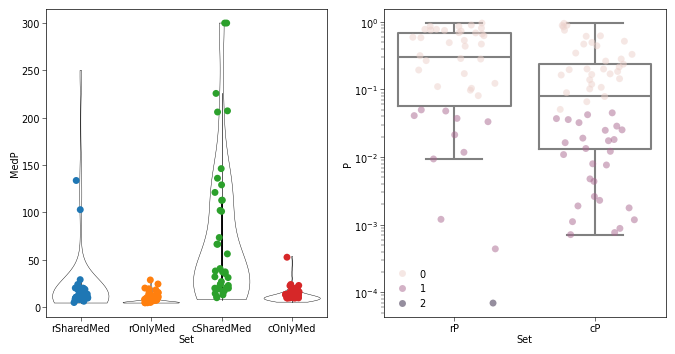

In [123]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.violinplot(test_df.melt(value_vars=['rSharedMed', 'rOnlyMed', 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, ax=ax1, fill=False, palette=['k','k','k', 'k'], linewidth=0.3)
sns.stripplot(test_df.dropna().melt(value_vars=['rSharedMed', 'rOnlyMed', 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', ax=ax1, edgecolor='black')
plot_df = test_df.melt(value_vars=['rP', 'cP'], var_name='Set', value_name='P')
plot_df['Sig'] = plot_df.P.apply(lambda x: 0 if x > 0.05 else 1 if x > 0.1/len(plot_df) else 2)
sns.stripplot(plot_df, jitter=0.3,
              x='Set', y='P', hue='Sig', log_scale=True, alpha=0.5, ax=ax2)
sns.boxplot(plot_df, x='Set', y='P', log_scale=True, fliersize=0, fill=False, color='grey', ax=ax2)

In [89]:
results_top = {}
for row in tqdm(top_over_df.iterrows()):
    results_top = {**results_top,  **compare_pval_dists(row[1]['StudyC'], row[1]['StudyR'], row[1]['EFO'])}
test_df_top = pd.DataFrame.from_dict(results_top, orient='index')

320it [00:08, 35.59it/s]


In [90]:
# proportion that could be assessed
len(test_df_top.dropna())/len(test_df_top)

0.140625

In [91]:
test_df_top2 = test_df_top.dropna()
test_df_top2.head()

,rStat,cStat,rP,cP,rSharedMed,rOnlyMed,cSharedMed,cOnlyMed
33230300.0_EFO_0005763_GCST90310296_EFO_0005763,319.0,7260.5,0.000439,0.884414,10.521434,8.033389,9.698970,9.698970
33230300.0_EFO_0006336_GCST90449057_EFO_0006336,281.0,2342.0,0.858302,0.008631,7.110698,8.127811,20.698970,10.154902
34226706.0_EFO_0007986_GCST90025970_EFO_0007986,59.5,27.0,0.000003,0.921053,15.065502,7.887345,23.301030,23.698970
33230300.0_EFO_0006335_GCST90449056_EFO_0006335,244.0,2209.0,0.138102,0.009340,8.698731,6.928118,15.522879,10.397940
36809768.0_EFO_0020946_GCST90269691_EFO_0020946,574.0,51.0,0.000069,0.468691,28.815632,10.608506,37.000000,23.698970


<Axes: xlabel='Set', ylabel='P'>

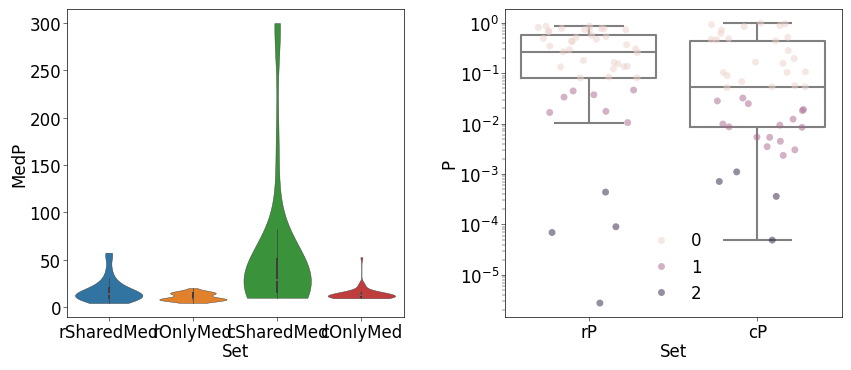

In [92]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'wspace':0.3})
sns.violinplot(test_df_top2.melt(value_vars=['rSharedMed', 'rOnlyMed', 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, ax=ax1)

plot_df = test_df_top2.melt(value_vars=['rP', 'cP'], var_name='Set', value_name='P')
plot_df['Sig'] = plot_df.P.apply(lambda x: 0 if x > 0.05 else 1 if x > 0.1/len(plot_df) else 2)
sns.stripplot(plot_df, jitter=0.3,
              x='Set', y='P', hue='Sig', log_scale=True, alpha=0.5, ax=ax2)
sns.boxplot(plot_df, x='Set', y='P', log_scale=True, fliersize=0, fill=False, color='grey', ax=ax2)

In [93]:
x = compare_global_p_dists(top_over_df)

320it [00:09, 34.04it/s]


<Axes: xlabel='Variant', ylabel='count'>

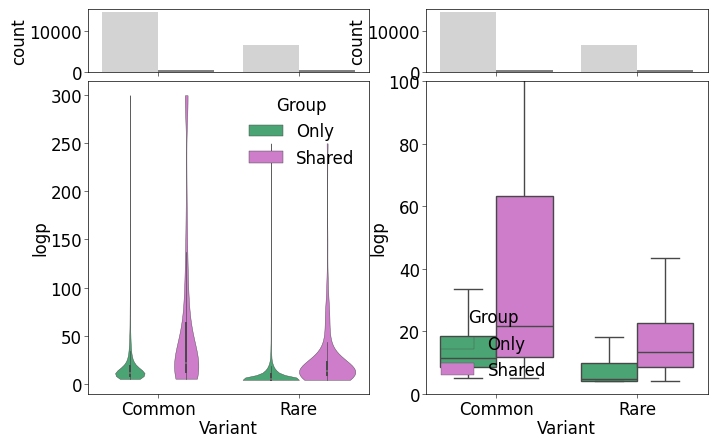

In [94]:
_, [[ax3,ax4], [ax1, ax2]] = plt.subplots(nrows=2, ncols=2, figsize=(8,5), sharex=True,
                                         gridspec_kw={'height_ratios':[1,5], 'hspace':0.05})
sns.violinplot(x, x='Variant', y='logp', hue='Group', cut=0, ax=ax1, palette=['mediumseagreen', 'orchid'])
sns.boxplot(x, x='Variant', y='logp', hue='Group', fliersize=0, ax=ax2, palette=['mediumseagreen', 'orchid'])
ax2.set_ylim(0,100)

sns.barplot(x.groupby('Variant').Group.value_counts().reset_index(), x='Variant', y='count', hue='Group', ax=ax3, 
           palette=['lightgrey', 'grey'], legend=False)
sns.barplot(x.groupby('Variant').Group.value_counts().reset_index(), x='Variant', y='count', hue='Group', ax=ax4,
           palette=['lightgrey', 'grey'], legend=False)

In [97]:
common = mannwhitneyu(x[(x.Variant=='Common') & (x.Group=='Only')].logp.values, x[(x.Variant=='Common') & (x.Group=='Shared')].logp.values)
common

MannwhitneyuResult(statistic=1723521.0, pvalue=2.5274769738986697e-49)

In [98]:
rare = mannwhitneyu(x[(x.Variant=='Rare') & (x.Group=='Only')].logp.values, x[(x.Variant=='Rare') & (x.Group=='Shared')].logp.values)
rare

MannwhitneyuResult(statistic=494577.5, pvalue=1.9521007663815244e-102)

### Look at reproducibility of shared vs common/rare only genes

## Example trait venn diagrams

In [123]:
traits = ['EFO_0004570', 'EFO_0009961', 'EFO_0004630',  'EFO_0000612',  'EFO_0000400', 'EFO_0000756', 'EFO_0000684']

In [126]:
top_over_df[top_over_df.EFO=='EFO_0000400']

,trait_pair,param_set,n_common,n_rare,n_overlap,background,pval,EFO,StudyC,StudyR,Expected,logp,rare_only,common_only,total,overlap+rare
655,34375979.0_EFO_0000400_GCST90246054_EFO_0000400,defaults,5,102,0,20000,0.025244,EFO_0000400,GCST90246054,34375979.0,0.056667,1.597847,102,5,107,102


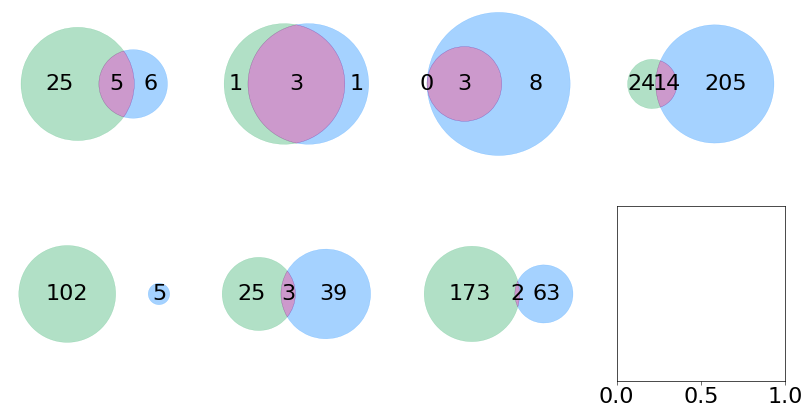

In [223]:
plt.rcParams.update({'font.size': 16})
_, [[ax1,ax2,ax3,ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(10, 5), sharex=False, sharey=True)
for i in range(len(traits)):
    trait_info = top_over_df[(top_over_df.EFO==traits[i]) & (top_over_df.param_set=='defaults')]
    subsets = trait_info.loc[:, ('rare_only', 'common_only', 'n_overlap')].values[0]
    v = venn2(subsets=subsets, set_labels=('', ''), ax=eval(f'ax{i+1}'))
    #eval(f'ax{i+1}').set_title(traits[i])
    try:
        v.get_patch_by_id('10').set_color('mediumseagreen')
        v.get_patch_by_id('01').set_color('dodgerblue')
        v.get_patch_by_id('11').set_color('purple')
    except:
        pass
plt.savefig(os.path.join(figdir, 'example_vens.jpg'), dpi=400, bbox_inches='tight')